In [1]:
import sys
print(sys.executable)
import warnings
warnings.filterwarnings("ignore")

c:\Users\benhu\UCL\Term 2\Data Science COMP0047\data-science-project\Scripts\python.exe


In [2]:
# Data manipulation / cleaning
import pandas as pd
import numpy as np

# Data visualization
import folium

# Plotting
import geopandas as gpd
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import seaborn as sns

# Machine Learning
from sklearn.cluster import KMeans

# Deep learning
import torch
import torch.nn as nn

In [ ]:
# Import global constants
from src.globals import (
    DATA_FOLDER,
    CLEAN_FOLDER,
    CLEAN_SUFFIX,
    WELLS_CSV,
    AD_HOC_WELLS_CSV,
    ASSETS_FOLDER,
)

In [ ]:
# Cleaning data from data\Wells.csv
wells_df = pd.read_csv(f'{DATA_FOLDER}/{WELLS_CSV}.csv');

# Remove leading and trailing whitespace in columns: 'well_name', 'well_number' and 12 other columns
wells_df['well_name'] = wells_df['well_name'].str.strip()
wells_df['well_number'] = wells_df['well_number'].str.strip()
wells_df['spud_date'] = wells_df['spud_date'].str.strip()
wells_df['country'] = wells_df['country'].str.strip()
wells_df['province_state'] = wells_df['province_state'].str.strip()
wells_df['county'] = wells_df['county'].str.strip()
wells_df['original_operator'] = wells_df['original_operator'].str.strip()
wells_df['current_operator'] = wells_df['current_operator'].str.strip()
wells_df['basin_name'] = wells_df['basin_name'].str.strip()
wells_df['current_status'] = wells_df['current_status'].str.strip()
wells_df['hole_direction'] = wells_df['hole_direction'].str.strip()
wells_df['td_tvd_uom'] = wells_df['td_tvd_uom'].str.strip()
wells_df['final_td_uom'] = wells_df['final_td_uom'].str.strip()
wells_df['datum'] = wells_df['datum'].str.strip()

# Drop duplicate rows across all columns
wells_df = wells_df.drop_duplicates()

# Drop rows with missing data in columns: 'country', 'county'
wells_df = wells_df.dropna(subset=['country'])

# Change column type to string for column: 'uwi'
wells_df = wells_df.astype({'uwi': 'string'})
wells_df.to_csv(f'{CLEAN_FOLDER}/{WELLS_CSV + CLEAN_SUFFIX}.csv')

In [8]:
# Cleaning data from data\adhoc_reports__wells_drilled_by_operator_with_depth.csv

wells_report_df = pd.read_csv(f'{DATA_FOLDER}/{AD_HOC_WELLS_CSV}.csv')

# Drop rows with missing data in columns: 'lon', 'lat', 'country'
wells_report_df = wells_report_df.dropna(subset=['lon', 'lat', 'country'])

# Remove leading and trailing whitespace in columns: 'date', 'country' and 2 other columns
wells_report_df['date'] = wells_report_df['date'].str.strip()
wells_report_df['country'] = wells_report_df['country'].str.strip()
wells_report_df['state'] = wells_report_df['state'].str.strip()
wells_report_df['operator'] = wells_report_df['operator'].str.strip()

# Drop duplicate rows across all columns
wells_report_df = wells_report_df.drop_duplicates()
# wells_report_df
wells_report_df.info()
wells_report_df.to_csv(f'{CLEAN_FOLDER}/{AD_HOC_WELLS_CSV + CLEAN_SUFFIX}.csv')

<class 'pandas.core.frame.DataFrame'>
Index: 942367 entries, 0 to 1048574
Data columns (total 7 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   date      849619 non-null  object 
 1   country   942367 non-null  object 
 2   state     942367 non-null  object 
 3   operator  934795 non-null  object 
 4   tvd       478601 non-null  float64
 5   lat       942367 non-null  float64
 6   lon       942367 non-null  float64
dtypes: float64(3), object(4)
memory usage: 57.5+ MB


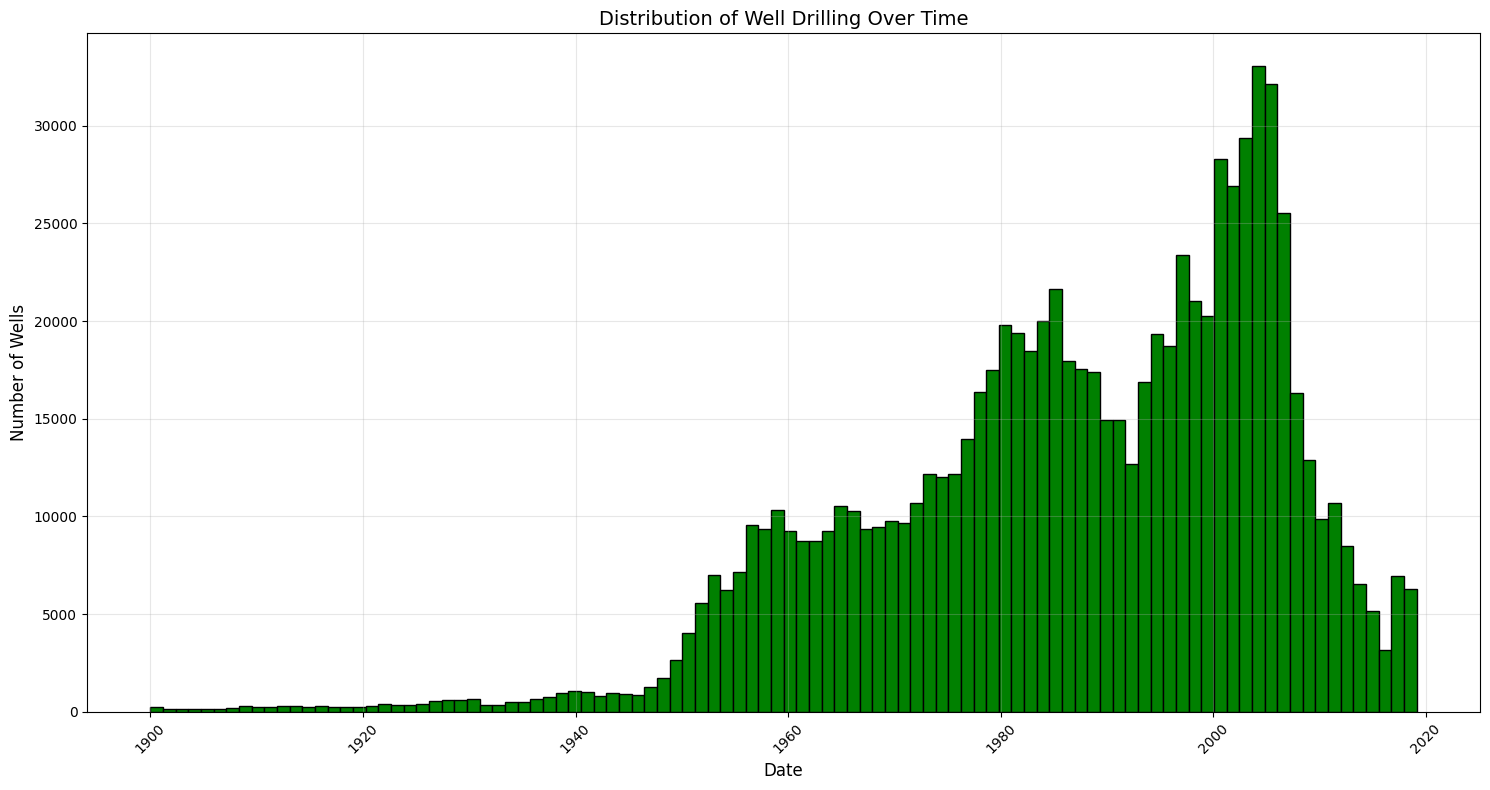

In [4]:
# Convert spud_date to datetime
# First try the standard format, if that fails use pd.to_datetime with format inference
wells_report_df['date'] = pd.to_datetime(wells_report_df['date'], format='%d/%m/%Y %H:%M', errors='coerce')

# Create figure with larger size
plt.figure(figsize=(15, 8))

# Create histogram
plt.hist(wells_report_df['date'].dropna(), bins=100, edgecolor='black', color='green')

# Customize the plot
plt.title('Distribution of Well Drilling Over Time', fontsize=14)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Number of Wells', fontsize=12)

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Add grid
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [5]:
# Merge the datasets into one for lats and longs
# Round coordinates to 6 decimal places to account for small differences
wells_df_min = wells_df[['surface_latitude', 'surface_longitude', 'final_td', 'country']].copy().dropna(subset=['surface_latitude', 'surface_longitude'])
wells_report_df_min = wells_report_df[['lat', 'lon', 'tvd', 'country']].copy().dropna(subset=['lat', 'lon'])

wells_df_min.drop_duplicates(inplace=True)
wells_report_df_min.drop_duplicates(inplace=True)

print("Before", wells_df_min.shape, wells_report_df_min.shape)
wells_merged = pd.merge(
    wells_df_min,
    wells_report_df_min,
    how='outer',
    left_on=['surface_latitude', 'surface_longitude'],
    right_on=['lat', 'lon'],
    suffixes=('_wells', '_adhoc')
)
# print(wells_merged['country_wells'].value_counts()['United States'])

# Fill in missing values with fields from the other dataset
wells_merged['lon'].fillna(wells_merged['surface_longitude'], inplace=True)
wells_merged['lat'].fillna(wells_merged['surface_latitude'], inplace=True)
wells_merged['tvd'].fillna(wells_merged['final_td'], inplace=True)
wells_merged['country_adhoc'].fillna(wells_merged['country_wells'], inplace=True)

# wells_merged = wells_merged['lat', 'lon', 'country_adhoc']
# wells_merged.drop_duplicates(inplace=True)
wells_merged.drop_duplicates(subset=['lat', 'lon', 'tvd', 'country_adhoc'], inplace=True)
print("After", wells_merged.shape)
wells_merged.rename(columns={'country_adhoc': 'country'}, inplace=True)
wells_merged[['lat', 'lon', 'tvd', 'country']].copy().to_csv('data/wells_merged.csv', index=False)

Before (618822, 4) (854247, 4)


C:\Users\benhu\AppData\Local\Temp\ipykernel_3508\2643613357.py:21: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  wells_merged['lon'].fillna(wells_merged['surface_longitude'], inplace=True)
C:\Users\benhu\AppData\Local\Temp\ipykernel_3508\2643613357.py:22: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always 

After (1365388, 8)


In [ ]:
# import folium

# Create a map centered at a specific latitude and longitude
sample_size = 1_000
wells_report_df_subset = wells_report_df.sample(sample_size).copy()
print(wells_report_df_subset)

m = folium.Map(location=[wells_report_df_subset.loc[:,'lat'].mean(), wells_report_df_subset.loc[:,'lon'].mean()], zoom_start=3)


for i in range(len(wells_report_df_subset)):
    # You can customize the marker with:
    # - popup: shows information when clicked
    # - tooltip: shows information on hover
    # - icon: customize the marker appearance
    folium.Marker(
        location=[
            wells_report_df_subset.iloc[i]['lat'],
            wells_report_df_subset.iloc[i]['lon']
        ],
        popup=f"Well {i}<br>Depth: {wells_report_df_subset.iloc[i]['tvd'] if pd.notna(wells_report_df_subset.iloc[i]['tvd']) else 'Unknown'}m",
        tooltip=f"Well {wells_report_df_subset.iloc[i]['operator'] if pd.notna(wells_report_df_subset.iloc[i]['operator']) else 'Unknown'}",
        icon=folium.Icon(color='blue', icon='glyphicon-info-sign')
    ).add_to(m)
    pass

m

                       date       country           state  \
566903                  NaT        Russia       Stavropol   
11677   2009-09-28 06:00:00        Canada         Alberta   
941256  1975-03-12 06:00:00       Romania           Bacau   
643101  1959-05-17 07:00:00       Algeria          Illizi   
665246  1974-09-25 06:00:00  Turkmenistan          Balkan   
...                     ...           ...             ...   
90429   1993-11-16 07:00:00        Canada         Alberta   
1026328 2004-07-15 06:00:00     Venezuela  Maracaibo Lake   
980696  2018-09-05 06:00:00        Canada         Alberta   
219946  1965-07-09 07:00:00        Canada         Alberta   
681849  1970-05-01 06:00:00     Venezuela  Maracaibo Lake   

                                          operator      tvd        lat  \
566903                           Stavropolneftegaz      NaN  44.779520   
11677              ConocoPhillips Canada (BRC) Ltd  2581.53  52.436470   
941256             Ministry of Petroleum (Rom

In [7]:
russia = wells_report_df[wells_report_df['country'] == 'Russia'].copy().reset_index(drop=True)
russia = russia.dropna(subset=['lat', 'lon']).reset_index(drop=True)
russia.shape

(56866, 7)

In [8]:
# Create a map centered at a specific latitude and longitude
m2 = folium.Map(location=[russia.loc[:, 'lat'].mean(), russia.loc[:, 'lon'].mean()], zoom_start=3)

for i in range(sample_size):
    folium.Marker([russia.loc[i, 'lat'], russia.loc[i, 'lon']]).add_to(m2)


m2

In [9]:
# countries = wells_report_df['country'].unique()
north_american_countries = [
    "Canada",
    "United States",
    "Mexico",
    "Belize",
    "Costa Rica",
    "El Salvador",
    "Guatemala",
    "Honduras",
    "Nicaragua",
    "Panama"
]

north_american_wells = wells_merged[wells_merged['country'].isin(north_american_countries)].copy().reset_index(drop=True)
north_american_wells_small = north_american_wells.sample(2000).copy().reset_index(drop=True)

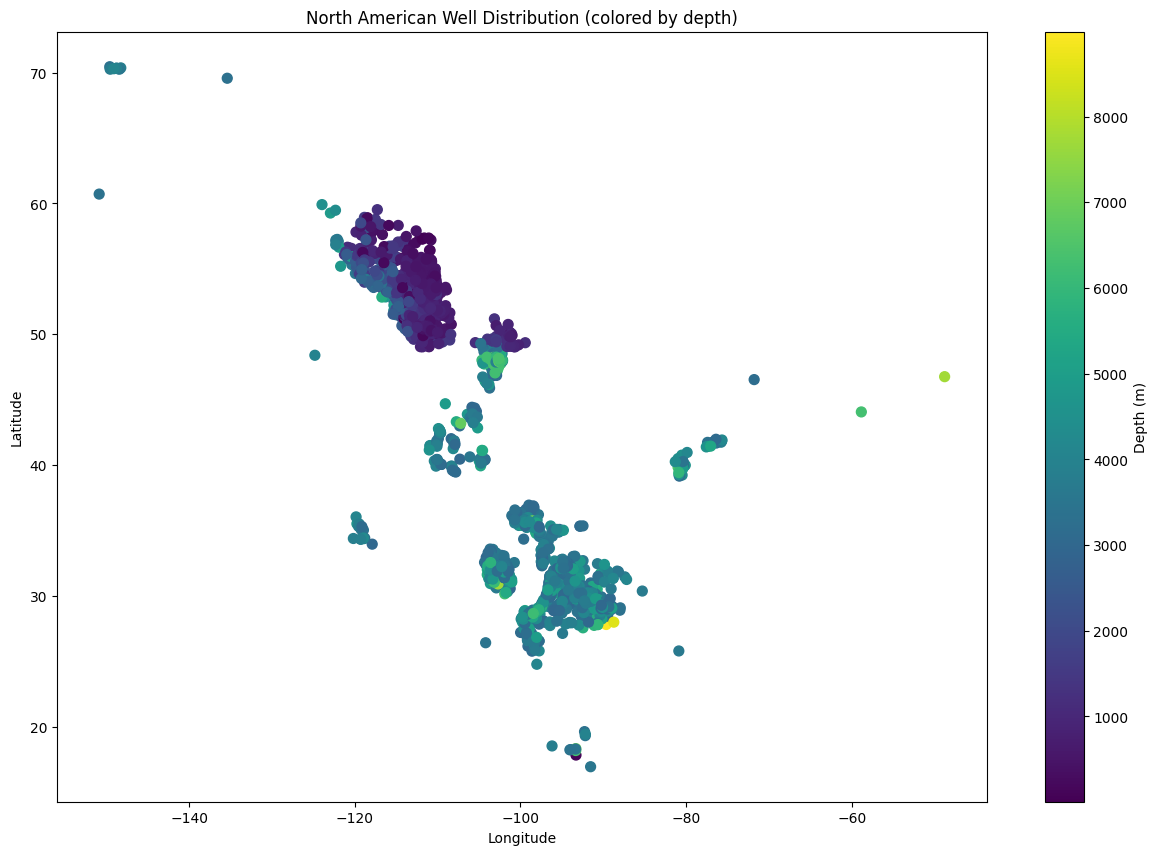

In [10]:
# Plotting long and lats for a sample of the north american wells
# import geopandas as gpd
# import matplotlib.pyplot as plt
# import plotly.graph_objects as go

# Convert your DataFrame to GeoDataFrame object
gdf = gpd.GeoDataFrame(
    north_american_wells_small,
    geometry=gpd.points_from_xy(
        north_american_wells_small.lon,
        north_american_wells_small.lat
    )
)

# Create the 3D scatter plot
fig = go.Figure()

# Add scatter points
fig.add_trace(
    go.Scatter3d(
        x=gdf.geometry.x,
        y=gdf.geometry.y,
        z=gdf.tvd,
        mode='markers',
        marker=dict(
            size=1,
            color=gdf.tvd,
            colorscale='viridis',
            colorbar=dict(title='Depth (m)')
        ),
        name='Wells'
    )
)

# Add vertical lines
for x, y, z in zip(gdf.geometry.x, gdf.geometry.y, gdf.tvd):
    fig.add_trace(go.Scatter3d(
        x=[x, x],
        y=[y, y],
        z=[0, z],
        mode='lines',
        line=dict(color='blue', width=1),
        opacity=0.1,
        showlegend=False
    ))

# Update layout
fig.update_layout(
    scene=dict(
        xaxis_title='Longitude',
        yaxis_title='Latitude',
        zaxis_title='Total Vertical Depth (m)',
        zaxis=dict(autorange='reversed')  # Invert z-axis
    ),
    title='Well Depths Distribution North America',
    height=800,  # Increase height to make plot taller
)
fig.show()

# Create a 2D scatter plot
plt.figure(figsize=(15, 10))


# Plot the points
scatter = plt.scatter(
    gdf.geometry.x,
    gdf.geometry.y,
    c=gdf.tvd,  # Color by depth
    cmap='viridis',
    s=50  # Point size
)

# Add labels and title
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('North American Well Distribution (colored by depth)')
plt.colorbar(scatter, label='Depth (m)')

plt.show()


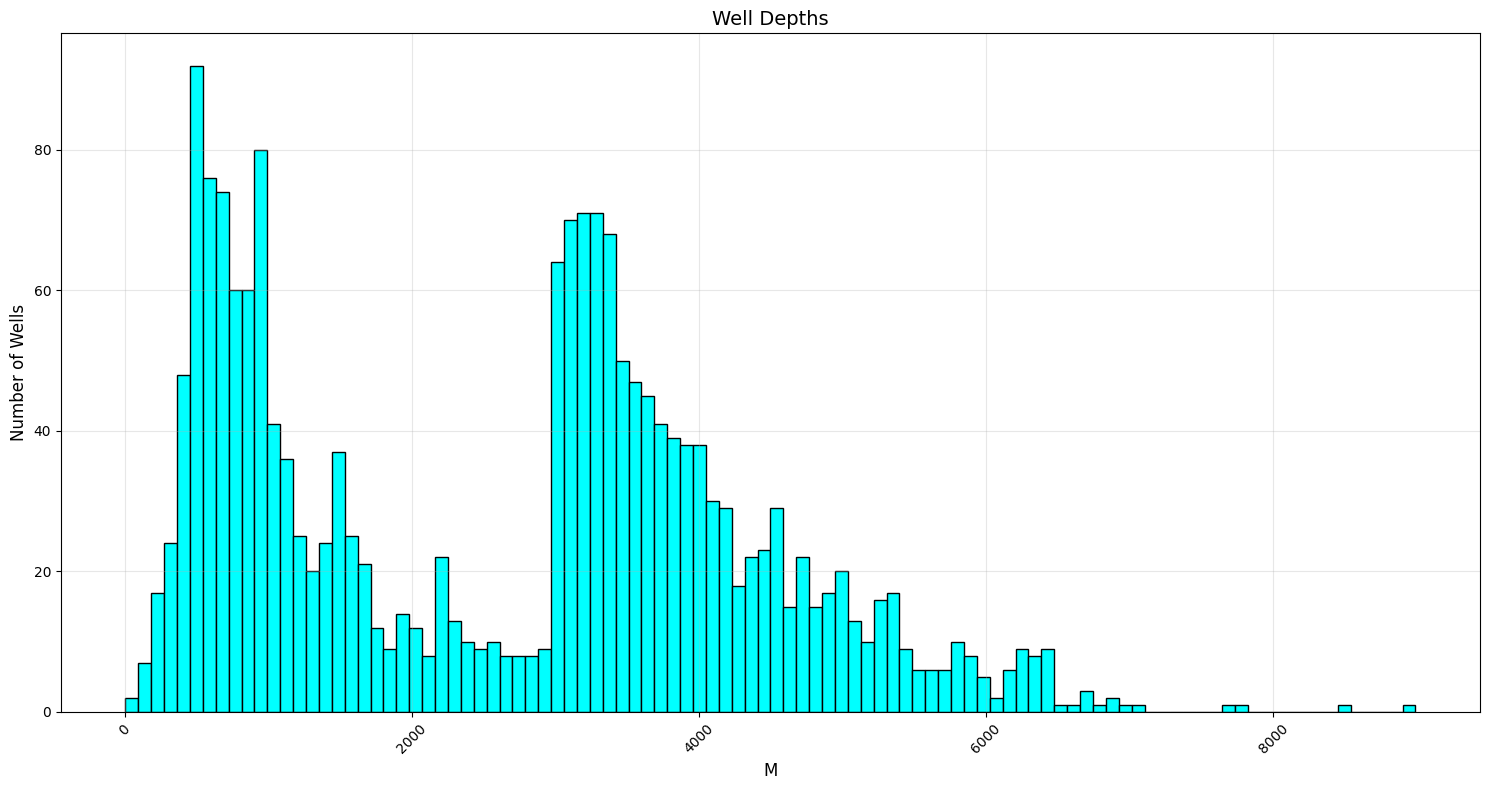

In [11]:
# plt.figure(10, 10)
# fig = plt.hist(gdf.tvd, bins=100)
# plt.show()

# Create figure with larger size
plt.figure(figsize=(15, 8))

# Create histogram
plt.hist(gdf['tvd'].dropna(), bins=100, edgecolor='black', color='cyan')

# Customize the plot
plt.title('Well Depths', fontsize=14)
plt.xlabel('M', fontsize=12)
plt.ylabel('Number of Wells', fontsize=12)

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Add grid
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

Canada            446130
United States     434515
Russia             53890
Argentina          34451
Venezuela          34390
Azerbaijan         33425
China              31790
Brazil             23254
Indonesia          20307
Kazakhstan         17235
Peru               13941
United Kingdom     13684
Other             208376
dtype: int64


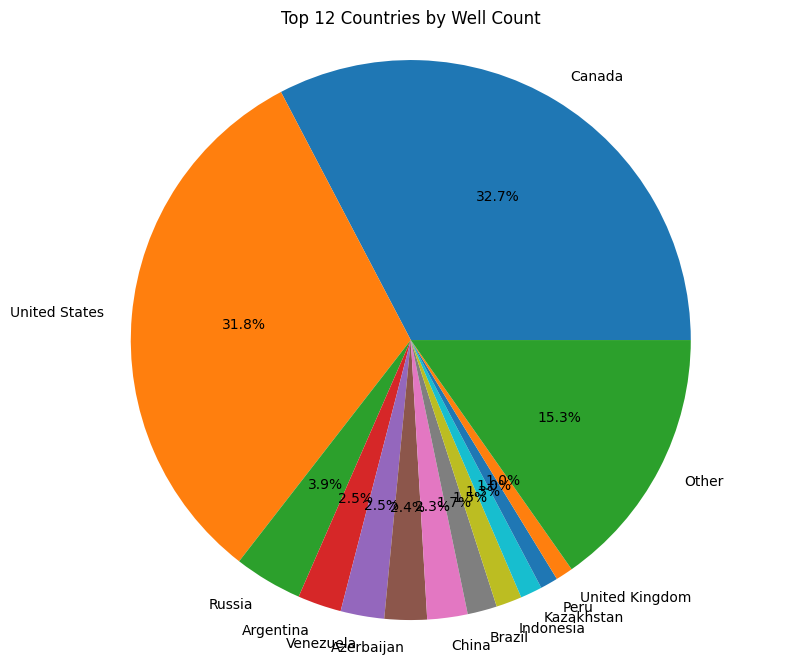

In [12]:
count_by_country = wells_merged['country'].value_counts()
show_top = 12
plt.figure(figsize=(10, 8))
pie_data = count_by_country.head(show_top)
pie_data = pd.concat([pie_data, pd.Series(count_by_country[show_top:].sum(), index=['Other'])])
print(pie_data)
plt.pie(pie_data, labels=pie_data.index, autopct='%1.1f%%')
plt.title(f'Top {show_top} Countries by Well Count')
plt.axis('equal')
plt.show()

In [13]:
# Plot 3d well trajectories

# Filter out rows where we have both surface and bottom hole coordinates
valid_wells = wells_df.dropna(
    subset=[
        'surface_latitude',
        'surface_longitude',
        'bottom_hole_latitude',
        'bottom_hole_longitude',
        'final_td'
    ]).sample(1000)

# Create a 3D scatter plot
fig = go.Figure()

# Add surface points
fig.add_trace(go.Scatter3d(
    x=valid_wells['surface_longitude'],
    y=valid_wells['surface_latitude'],
    z=np.zeros(len(valid_wells)),  # Surface points at z=0
    mode='markers',
    name='Surface Location',
    marker=dict(size=1, color='blue')
))

# Add bottom hole points
fig.add_trace(go.Scatter3d(
    x=valid_wells['bottom_hole_longitude'],
    y=valid_wells['bottom_hole_latitude'],
    z=valid_wells['final_td'],
    mode='markers',
    name='Bottom Hole Location',
    marker=dict(size=1, color='red')
))

# Add 3D lines connecting surface to bottom hole
for _, well in valid_wells.iterrows():
    fig.add_trace(go.Scatter3d(
        x=[well['surface_longitude'], well['bottom_hole_longitude']],
        y=[well['surface_latitude'], well['bottom_hole_latitude']],
        z=[0, well['final_td']],  # From surface (0) to final depth
        mode='lines',
        line=dict(
            # Color based on depth
            colorscale='Magma',    # Other options include: 'Plasma', 'Inferno', 'Magma', 'Cividis', 'Rainbow', 'RdBu', 'Blues', 'Hot'
            width=1
        ),
        showlegend=False
    ))

# Update layout
fig.update_layout(
    title='3D Well Trajectories',
    scene=dict(
        xaxis_title='Longitude',
        yaxis_title='Latitude',
        zaxis_title='Depth (m)',
        zaxis=dict(
            autorange='reversed'  # Reverse z-axis to show depth going down
        )
    ),
    scene_camera=dict(
        up=dict(x=0, y=0, z=1),
        center=dict(x=0, y=0, z=0),
        eye=dict(x=1.5, y=1.5, z=1.5)
    ),
    showlegend=True,
    template='plotly_white',
    height=1000,  # Increase height to make plot taller
)

fig.show()

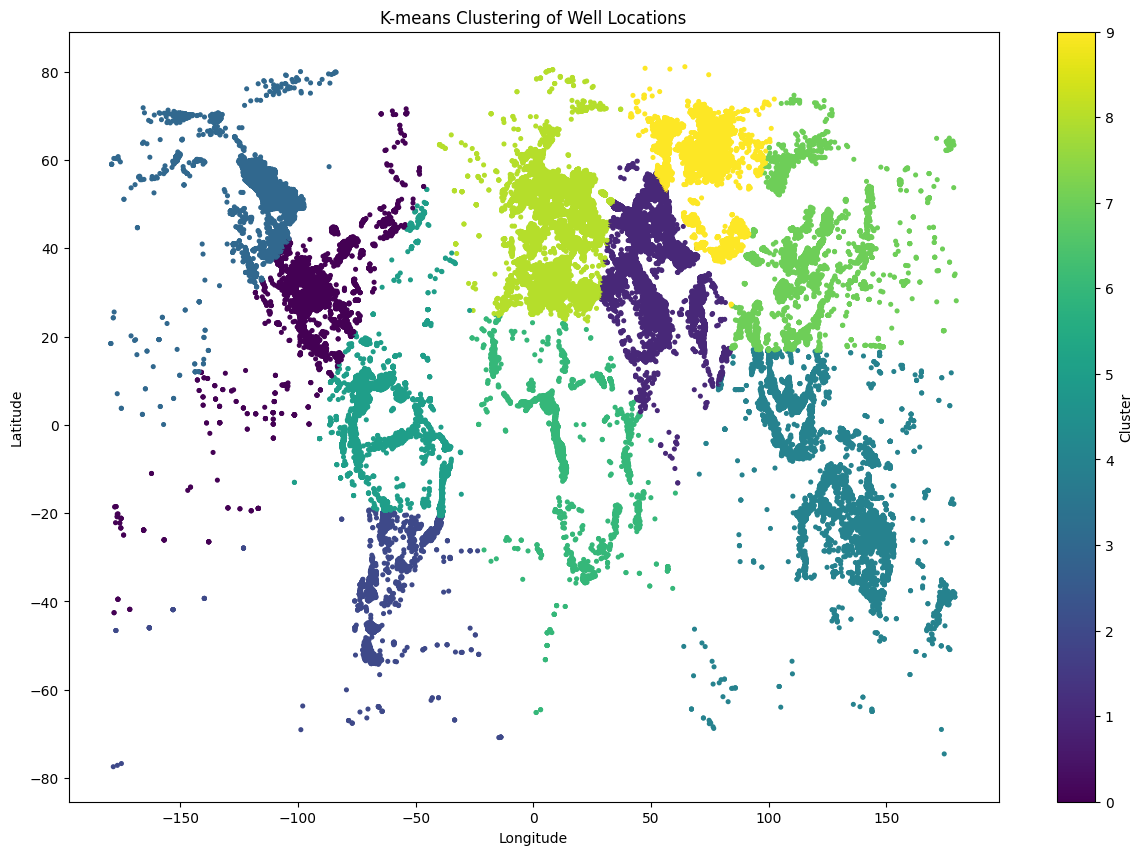


Cluster Centers:
       lat       lon
0  31.5207  -96.1197
1  38.1463   50.4718
2 -40.4723  -65.7695
3  51.9048 -112.6278
4  -5.2780  116.7319
5   1.9563  -63.5384
6  -0.3542    9.9431
7  38.9021  117.1668
8  46.8201   12.9090
9  59.1679   71.0828


In [14]:
# Perfporing K-means clustering on the well locations

# from sklearn.cluster import KMeans
# import numpy as np

# Extract lat and lon into a numpy array for clustering
merged_copy = wells_merged.copy()
coords = merged_copy[['lat', 'lon']].values

# Try with 5 clusters - you can adjust this number
n_clusters = 10
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
merged_copy['cluster'] = kmeans.fit_predict(coords)

# Create a plot showing the clusters
plt.figure(figsize=(15, 10))
scatter = plt.scatter(
    merged_copy['lon'],         # x-coordinates (longitude)
    merged_copy['lat'],         # y-coordinates (latitude)
    c=merged_copy['cluster'],   # color points by cluster assignment (0-4)
    cmap='viridis',             # color scheme to use
    s=7                         # size of scatter points
)
plt.colorbar(scatter, label='Cluster')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('K-means Clustering of Well Locations')
plt.show()

# Print cluster centers
cluster_centers = pd.DataFrame(
    kmeans.cluster_centers_, 
    columns=['lat', 'lon']
).round(4)
print("\nCluster Centers:")
print(cluster_centers) 

In [15]:
# Long lat function to map to 3D
def long_lat_to_3d(lat, lon, radius=1):
    lat = np.radians(lat)
    lon = np.radians(lon)

    x = radius * np.cos(lat) * np.cos(lon)
    y = radius * np.cos(lat) * np.sin(lon)
    z = radius * np.sin(lat)
    return x, y, z

In [16]:
# Plotting the 3D clusters

# Generate sphere coordinates
phi, theta = np.mgrid[0:np.pi:20j, 0:2*np.pi:40j]
x = np.sin(phi) * np.cos(theta)
y = np.sin(phi) * np.sin(theta)
z = np.cos(phi)

# Create plot
fig = go.Figure()

# Sphere surface
fig.add_trace(
    go.Surface(
        z=z,
        x=x,
        y=y,
        # colorscale="Blues",
        opacity=0.9
    )
)

# Add random points
threeD_sample_size = 100_000
test_3d_points = wells_merged.sample(threeD_sample_size).copy().reset_index(drop=True)
data_x2 = []; data_y2 = []; data_z2 = []

# Find the scaled long and lats for each samplen point
for i in range(len(test_3d_points)):
    x, y, z = long_lat_to_3d(test_3d_points.loc[i, 'lat'], test_3d_points.loc[i, 'lon'], radius=1)
    data_x2.append(x)
    data_y2.append(y)
    data_z2.append(z)

# Add 3D scatter plot
fig.add_trace(
    go.Scatter3d(
        x=data_x2,
        y=data_y2,
        z=data_z2,
        mode='markers',
        marker=dict(
            size=2.5,
            color=test_3d_points['cluster'],
            colorscale='Viridis',
            opacity=0.8
        )
    )
)

# Update layout
fig.update_layout(
    height=900,
    showlegend=False,
    scene=dict(
        # xaxis_title='X',
        # yaxis_title='Y',
        # zaxis_title='Z',
        camera=dict(
            up=dict(x=0, y=0, z=1),
            center=dict(x=0, y=0, z=0),
            eye=dict(x=1.2, y=1.2, z=1.2)  # Reduced from 1.5 to zoom in more
        )
    ),
    title='3D Clustering of Well Locations',
    template='plotly_white'
)

fig.show()


KeyError: 'cluster'

In [ ]:
count_by_country = wells_merged['country'].value_counts()
count_by_country

country
Canada                       446130
United States                434515
Russia                        53890
Argentina                     34451
Venezuela                     34390
                              ...  
Central African Republic          1
Nepal                             1
British Virgin Islands            1
San Marino                        1
Saint Pierre and Miquelon         1
Name: count, Length: 215, dtype: int64

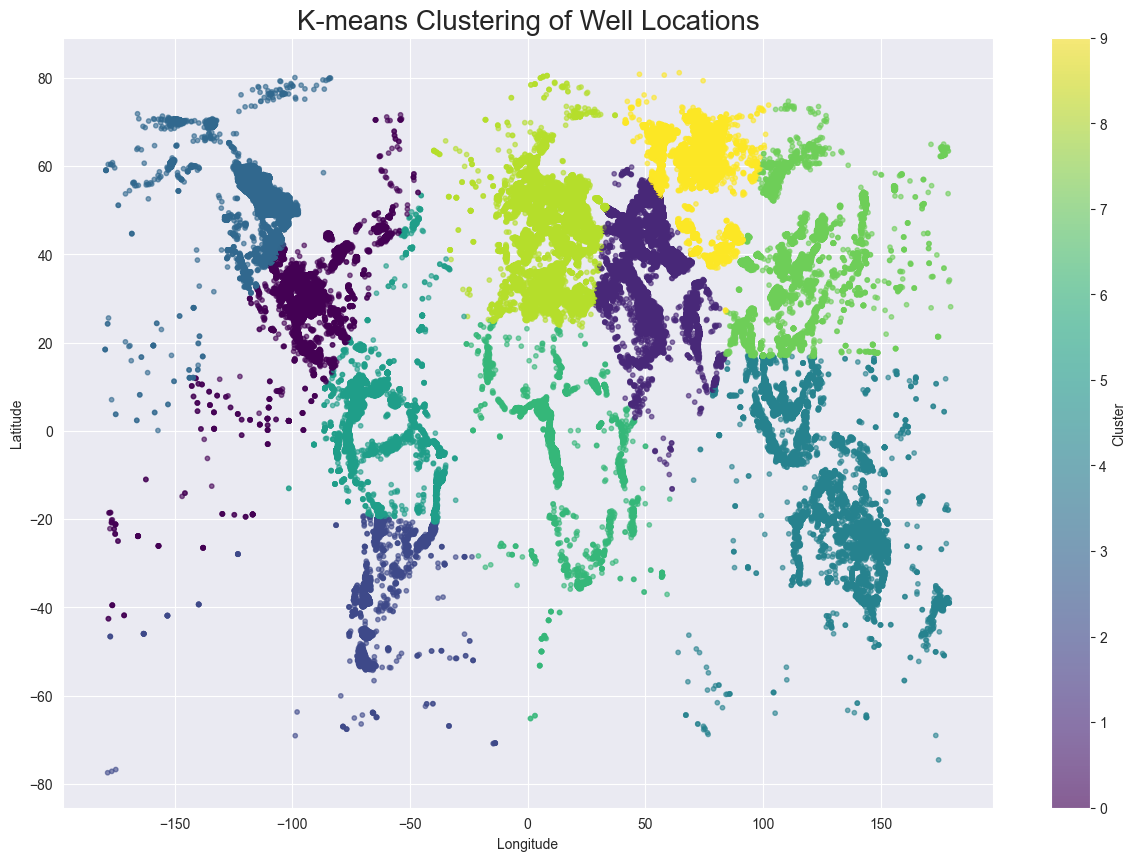

In [ ]:
wells_merged.dropna(subset=['lat', 'lon'], inplace=True)
coords = wells_merged[['lat', 'lon']].values

# Try with 5 clusters - you can adjust this number
n_clusters = 10
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
wells_merged['cluster'] = kmeans.fit_predict(coords)

plt.figure(figsize=(15, 10))
sns.set_style("darkgrid")
scatter = plt.scatter(
    wells_merged['lon'],         # x-coordinates (longitude)
    wells_merged['lat'],         # y-coordinates (latitude)
    c=wells_merged['cluster'],   # color points by cluster assignment 
    cmap='viridis',                 # color scheme to use
    s=10,                           # size of scatter points
    alpha=0.6                       # add some transparency
)
plt.colorbar(scatter, label='Cluster')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('K-means Clustering of Well Locations', fontsize=20)
plt.show()

# Print cluster centers
cluster_centers = pd.DataFrame(
    kmeans.cluster_centers_, 
    columns=['lat', 'lon']
).round(4)
# print("\nCluster Centers:")
# print(cluster_centers) 

Mean percentage accuracy : 87.18845352776532
Standard Deviation: 42.957646052414816
Mean percentage accuracy : 85.7803266526254
Standard Deviation: 38.13389100554908
Mean percentage accuracy : 84.4663978821641
Standard Deviation: 41.95038182812371
Mean percentage accuracy : 84.22906166123424
Standard Deviation: 52.859828304535974
Mean percentage accuracy : 85.88505649142485
Standard Deviation: 29.020045612497498
Mean percentage accuracy : 83.6652164549192
Standard Deviation: 43.68371682289286
Mean percentage accuracy : 84.84881434499624
Standard Deviation: 49.138542243335266
Mean percentage accuracy : 85.0078107627508
Standard Deviation: 35.901639948416694
Mean percentage accuracy : 83.5586322720165
Standard Deviation: 48.81545614700695
Mean percentage accuracy : 84.19735218311196
Standard Deviation: 39.8511568805887
Mean percentage accuracy : 84.07269148529053
Standard Deviation: 50.639263853093
Mean percentage accuracy : 83.28297082370658
Standard Deviation: 69.13799360966215
Mean pe

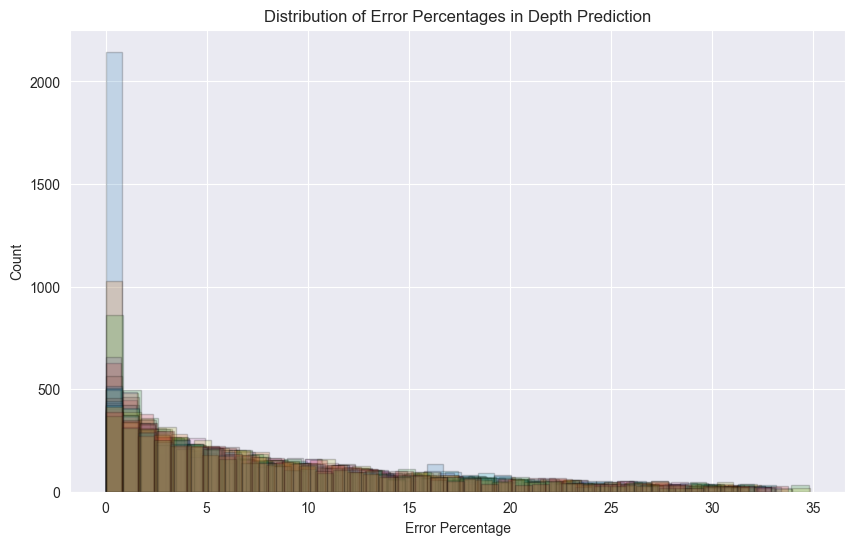

In [ ]:
# Well depeth K nearest neighbour regression
from sklearn.neighbors import KNeighborsRegressor

train_size = 300_000
test_size = 5_000

train_knn_df = wells_merged[['lat', 'lon', 'tvd','country']].copy().dropna(subset=['lat', 'lon', 'tvd']).sample(train_size).reset_index(drop=True)

# Number of neighbours (hyperparameter)

K = [n for n in range(1, 25)]
error_per_k = []
sd_per_k = []

# Create a KNN model
# accuracy = knn.score(test_knn_df[['lat', 'lon']], test_knn_df['tvd'])

# Setup the plot
plt.figure(figsize=(10, 6))
plt.title('Distribution of Error Percentages in Depth Prediction')
plt.xlabel('Error Percentage')
plt.ylabel('Count')


# For different values of k, test the KNN algorithm
for k in K:
    
    # Define and train the knn model
    knn = KNeighborsRegressor(n_neighbors=k)
    knn.fit(train_knn_df[['lat', 'lon']], train_knn_df['tvd'])
    
    accuracy = np.array([0.0 for i in range(test_size)])
    error_pcnt = np.array([0.0 for i in range(test_size)])
    
    # Reset the test dataset    
    test_knn_df = wells_merged[['lat', 'lon', 'tvd','country']].copy().dropna(subset=['lat', 'lon', 'tvd']).sample(test_size).reset_index(drop=True)

    
    for i in range(test_size):
        
        # Get random index
        random_idx = np.random.choice(test_knn_df.index)

        # Get coordinates for this point
        test_point = test_knn_df.loc[random_idx, ['lat', 'lon']].values.reshape(1, -1)
        true_depth = test_knn_df.loc[random_idx, 'tvd']
        country = test_knn_df.loc[random_idx, 'country']

        # Predict depth using KNN
        predicted_depth = knn.predict(test_point)[0]
        accuracy[i] = (1 - abs(predicted_depth - true_depth) / true_depth) * 100
        error_pcnt[i] = abs(predicted_depth - true_depth) / true_depth * 100

    print(f"Mean percentage accuracy : {accuracy.mean()}")
    print(f"Standard Deviation: {accuracy.std()}")
    error_per_k.append(error_pcnt.mean())
    sd_per_k.append(error_pcnt.std())
    
    # Plotting histogram of error percentage
    error_pcnt_filtered = error_pcnt[error_pcnt < np.percentile(error_pcnt, 90)]
    plt.hist(error_pcnt_filtered, bins=40, edgecolor='black', alpha=0.2)

plt.show()


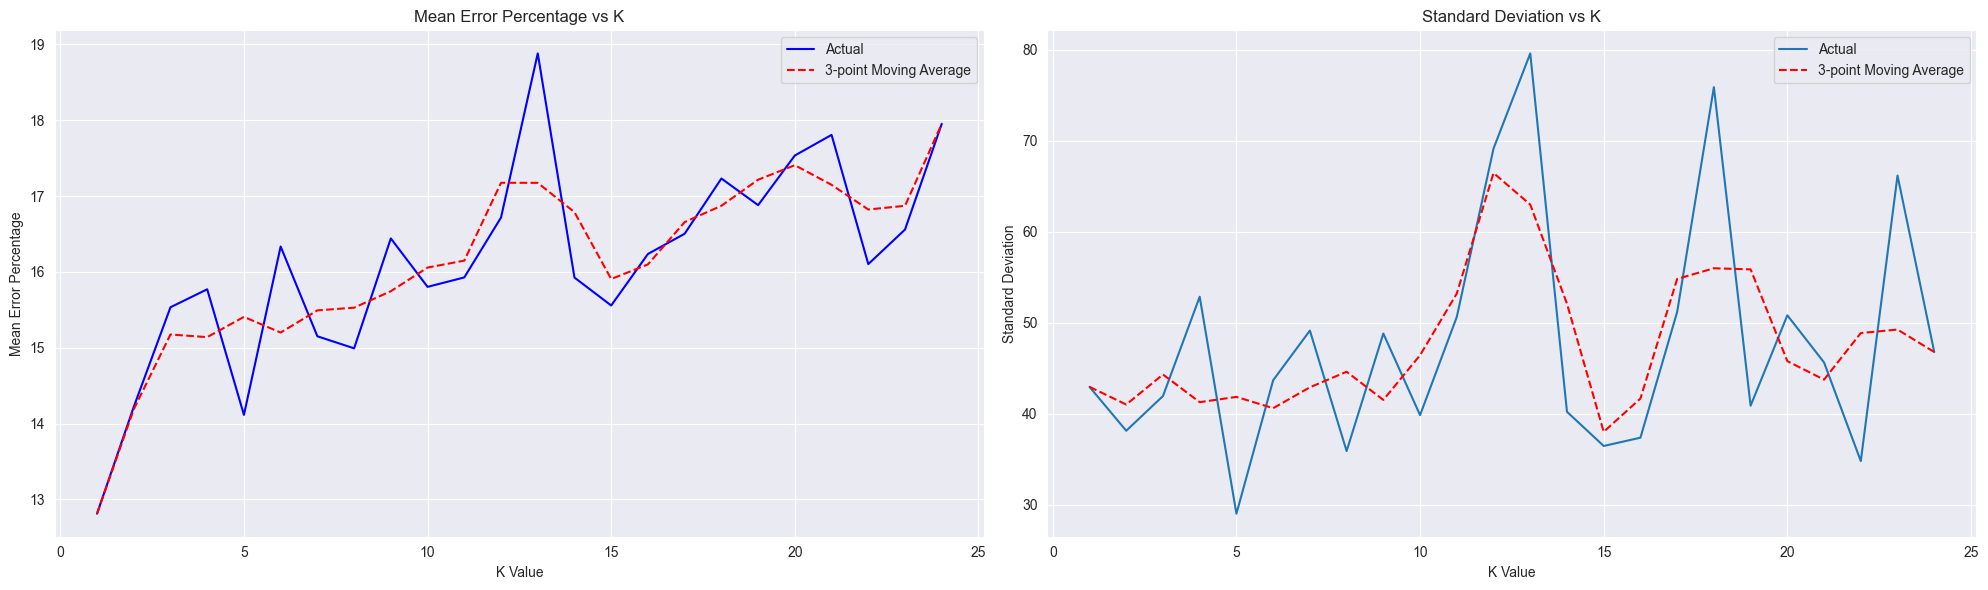

In [ ]:
# Visualize the output of the K Means Regression

# Create a figure with two subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 6))

# Plot mean error on the left subplot
ax1.plot(K, error_per_k, 'b-', label='Actual')
# Calculate 3-point moving average
moving_avg_mean_error = []
for i in range(len(error_per_k)):
    if i < 1:
        moving_avg_mean_error.append(error_per_k[i])
    elif i > len(error_per_k)-2:
        moving_avg_mean_error.append(error_per_k[i])
    else:
        avg = sum(error_per_k[i-1:i+2])/3
        moving_avg_mean_error.append(avg)
ax1.plot(K, moving_avg_mean_error, 'r--', label='3-point Moving Average')
ax1.legend()
ax1.set_title('Mean Error Percentage vs K')
ax1.set_xlabel('K Value')
ax1.set_ylabel('Mean Error Percentage')
ax1.grid(True)

moving_avg_error_stddev = []
# Calculate 3-point moving average
for i in range(len(sd_per_k)):
    if i < 1:
        moving_avg_error_stddev.append(sd_per_k[i])
    elif i > len(sd_per_k)-2:
        moving_avg_error_stddev.append(sd_per_k[i])
    else:
        avg = sum(sd_per_k[i-1:i+2])/3
        moving_avg_error_stddev.append(avg)

# Plot standard deviation on the right subplot
ax2.plot(K, sd_per_k, label='Actual')
ax2.plot(K, moving_avg_error_stddev, 'r--', label='3-point Moving Average')
ax2.legend()
ax2.set_title('Standard Deviation vs K')
ax2.set_xlabel('K Value')
ax2.set_ylabel('Standard Deviation')
ax2.grid(True)

plt.tight_layout()
plt.show()